In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [27]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, padding='same'),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 32, kernel_size=3, padding='same'),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 16, kernel_size=3, padding='same'),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2)
        )
        
        self.decoder = torch.nn.Sequential(
           torch.nn.Conv2d(16, 32, (3, 3), padding='same'),
           torch.nn.ReLU(True),
           torch.nn.Upsample(size=(7, 7)),
           torch.nn.Conv2d(32, 64, (3, 3), padding='same'),
           torch.nn.ReLU(True),
           torch.nn.Upsample(size=(14, 14)),
           torch.nn.Conv2d(64, 1, (3, 3), padding='same'),
           torch.nn.ReLU(True),
           torch.nn.Upsample(size=(28, 28)),
       )
            
        self.optimizer = torch.optim.SGD(self.parameters(), lr=1e-2)
        self.loss = torch.nn.MSELoss()
    
    def forward(self, x):
        y = self.encoder(x)
        y = self.decoder(y)
        return y

In [28]:
def train_encoder(encoder, x):
    pred = encoder.forward(x)
    loss = encoder.loss(pred, x)
    encoder.optimizer.zero_grad()
    loss.backward()
    encoder.optimizer.step()
    l = float(loss)
    return l

In [29]:
data = datasets.FashionMNIST("Fashion", download=True, transform=transforms.ToTensor())

In [30]:
auto_encoder = AutoEncoder()
auto_encoder

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): Upsample(size=(7, 7), mode=nearest)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU(inplace=True)
    (5): Upsample(size=(14, 14), mode=nearest)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU

In [31]:
loaded = torch.utils.data.DataLoader(data, batch_size=2048, shuffle=True)

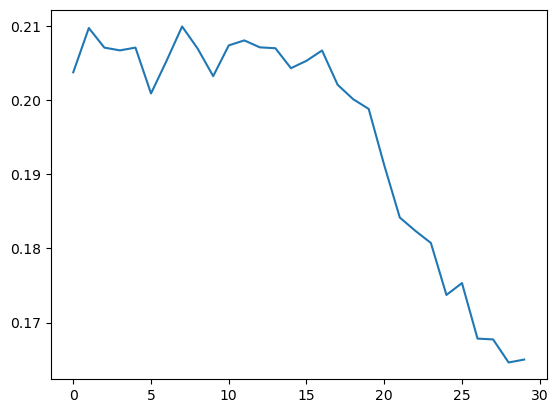

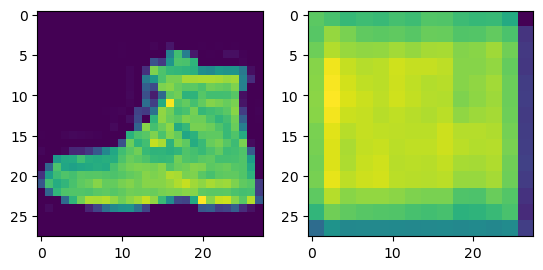

In [32]:
%matplotlib inline
loss = []
max = 100
for data in loaded:
    #print(data[0].shape)
    loss.append(train_encoder(auto_encoder, data[0]))
    max -= 1
    if max < 0:
        break
plt.plot(loss)
plt.figure()
image = next(d for d in loaded)[0][0].reshape(28, 28)
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(auto_encoder.forward(image.reshape(1, 1, 28, 28)).detach().reshape(28, 28))